# Clustering with Derived Variables

First let's load the data.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Filter_Unmerged.csv').drop(columns = ['Unnamed: 0'])
df.head()

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,3PM,FGM,FGA,PTS,MINS,AST,REB,BLK,TOV,STL
0,Alex Abrines,Okc,G,25.69,31,19.0,39.5,12.2,7.9,13,...,41.021,56.021,157,164.3,589.0,18.6,46.5,5.89,13.95,17.05
1,Jaylen Adams,Atl,G,22.93,34,12.6,26.2,13.5,19.7,9,...,25.012,38.008,110,108.8,428.4,64.6,61.2,5.10,27.88,12.92
2,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,12.8,292,...,0.000,480.972,809,1112.0,2672.0,128.0,760.0,76.80,138.40,119.20
3,Bam Adebayo,Mia,C,21.73,82,23.3,48.6,15.8,17.1,226,...,3.000,279.948,486,729.8,1910.6,180.4,598.6,64.78,121.36,72.16
4,Deng Adel,Cle,F,22.19,19,10.2,21.3,9.9,13.7,4,...,6.003,11.008,36,32.3,193.8,5.7,19.0,3.99,6.08,0.95


## Cleaning

Need to fix this column.

In [22]:
df['3P%'] = df['3P%'].apply(lambda x: x if x <= 1 else (x/100))

### Feature Engineering

Let's create some new columns that will be more usful in calssifying players acccording to their styles.

In [23]:
for col in ['PTS', 'AST', 'REB', 'BLK', 'TOV', 'STL']:
    df[col + 'P36'] = df[col] * 36 / df['MINS']
df['O/DRTG'] = df['ORTG'] / df['DRTG']
df['3/2FGA'] = df['3PA'] / df['2PA']
df['%FTA'] = df['FTA'] / (df['FGA'] + df['FTA'])
print(list(df.columns))

['FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'Tor%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', '2PM', '3PM', 'FGM', 'FGA', 'PTS', 'MINS', 'AST', 'REB', 'BLK', 'TOV', 'STL', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', 'O/DRTG', '3/2FGA', '%FTA']


### Feature Selection

Here, we create a list of the columns we want to use as parameters to the clustering alrogithm, called `cols_to_keep`. We ensure that none of these columns contain missing values.

In [24]:
cols_to_keep = ['USG%', 'Tor%', 'TS%', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', '3/2FGA', '%FTA']
cluster_df = df[cols_to_keep]
cluster_df.isnull().sum().sum()

0

Let's take a look at the correlation of these stats.

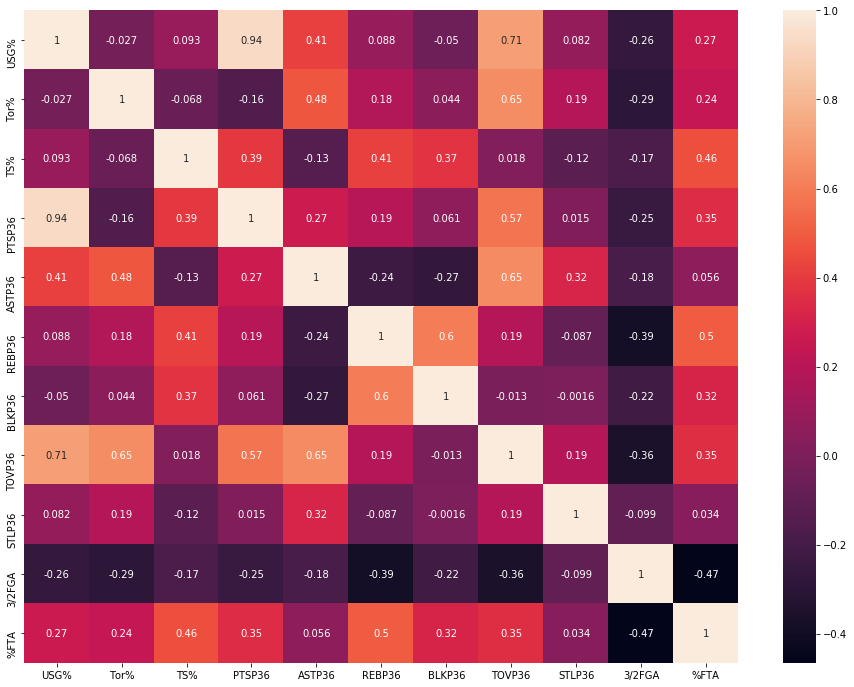

In [25]:
import seaborn as sn
plt.figure(figsize=(16,12))
sn.heatmap(cluster_df.corr(), annot=True)
plt.show()

We can also take a look at the distributions of each stat.

In [26]:
df[cols_to_keep].describe()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,3/2FGA,%FTA
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,18.785852,12.154455,0.548287,15.337947,3.385311,6.733290,0.764913,1.925235,1.112010,0.790635,0.193341
std,5.180464,3.528923,0.056510,4.707338,2.000050,3.116203,0.701144,0.759908,0.421685,0.829109,0.073030
min,7.771832,3.700000,0.309569,3.380171,0.564706,1.963636,0.000000,0.400000,0.000000,0.000000,0.000000
25%,15.100000,9.700000,0.518000,11.999691,1.862069,4.355428,0.320857,1.350545,0.801799,0.337386,0.140104
50%,17.825402,11.700000,0.552014,14.764671,2.730166,5.926346,0.554621,1.797589,1.064018,0.614023,0.186958
75%,22.100000,14.200000,0.583000,18.069771,4.581818,8.641840,0.984609,2.334836,1.342849,1.076719,0.239867
max,40.500000,26.800000,0.720000,35.315217,10.700000,17.613734,5.337931,4.852174,2.537705,10.615385,0.467742


And, finally, let us plot histograms of the columns.

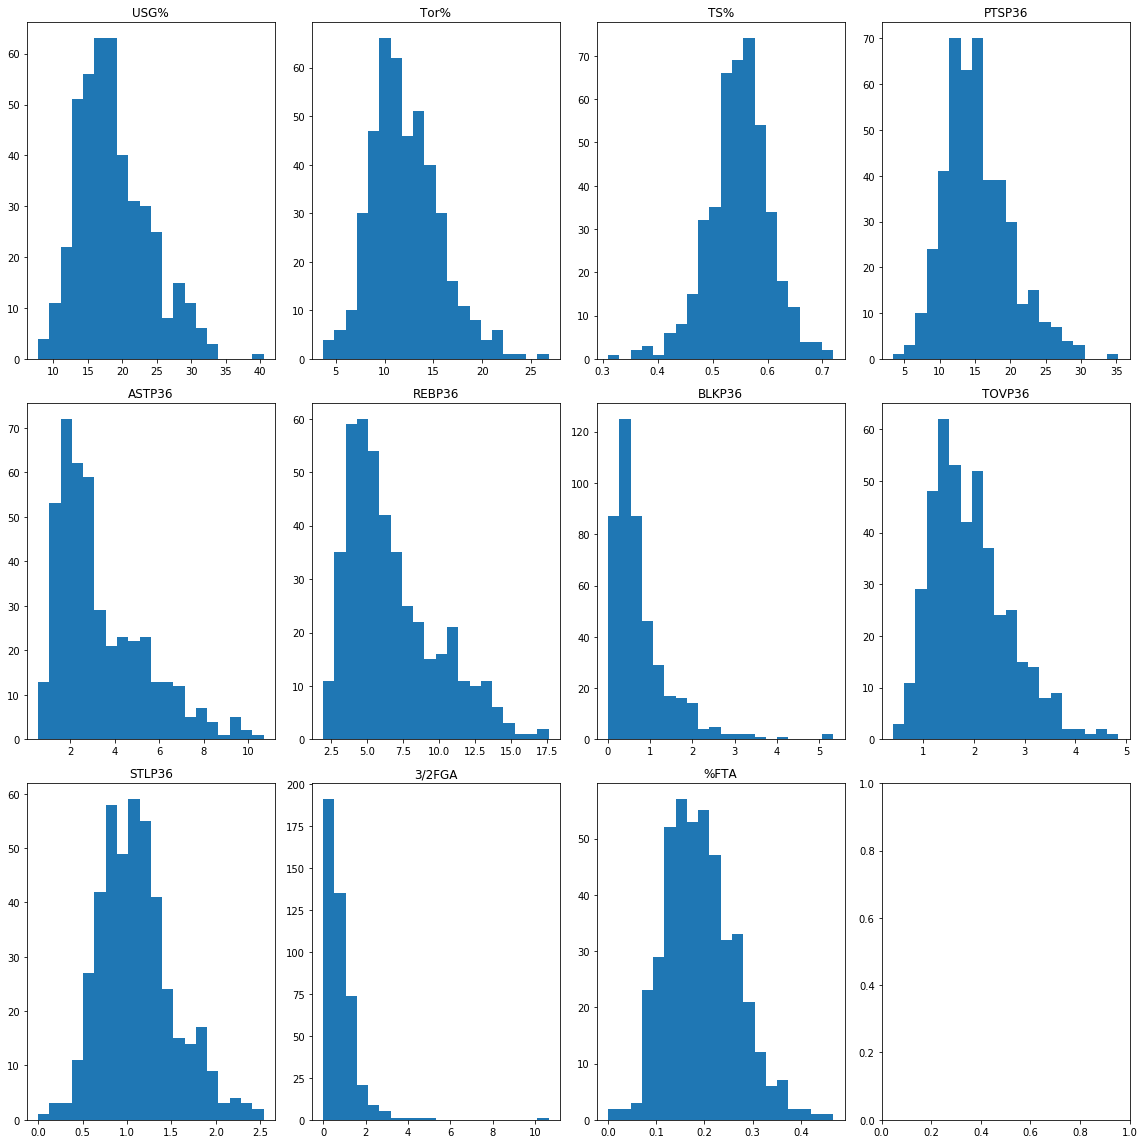

In [27]:
plt.subplots(3, 4, figsize=(16, 16))
for i in range(len(cols_to_keep)):
    plt.subplot(3, 4, i+1)
    plt.hist(cluster_df[cols_to_keep[i]], bins=20)
    plt.title(cols_to_keep[i])
    plt.tight_layout()
plt.show()

### Standardization

From these distributions, it seems the selected stats are approximately normally distributed. In order to avoid scaling issues, let us standardize the columns with z-scores.

In [28]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
cluster_df = pd.DataFrame(scaler.fit_transform(cluster_df), columns=cols_to_keep)
cluster_df.head()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,3/2FGA,%FTA
0,-1.272733,-1.206968,-0.731435,-1.126299,-1.125486,-1.250116,-0.578160,-1.413097,-0.165965,4.157012,-1.602126
1,-1.021505,2.140634,-1.316064,-1.317547,1.022768,-0.510956,-0.480250,0.550195,-0.062431,1.527374,-1.613645
2,-0.461072,0.183138,0.756711,-0.075694,-0.831305,1.126442,0.385263,-0.079790,1.172771,-0.951689,0.985258
3,-0.577024,1.403027,1.323624,-0.337490,0.006923,1.460384,0.650660,0.476204,0.587946,-0.916227,1.700873
4,-1.717214,0.438463,-2.201865,-1.985958,-1.164539,-1.029306,-0.033892,-1.048454,-2.221101,1.181641,-1.279572


### Clustering

Let us try models with the number of clusters ranging from 5 to 15.

In [29]:
from sklearn.cluster import KMeans
inertias = []
num_data = cluster_df._get_numeric_data().dropna(axis = 1)
for i in range(5, 15):
    test_model = KMeans(n_clusters = i, random_state = 1) #test using just 5 clusters
    test_model.fit(num_data)
    inertias.append(test_model.inertia_)
print(inertias)

[2645.7888505554615, 2507.578489287983, 2379.615237764683, 2278.355987610571, 2189.5692467058575, 2097.5582541429203, 2007.5915034451295, 1929.2317658908914, 1878.4095181921966, 1843.6703607696725]


We create a plot of the "intertias" per number of clusteras and use the elbow method to determine the best number of clusters.

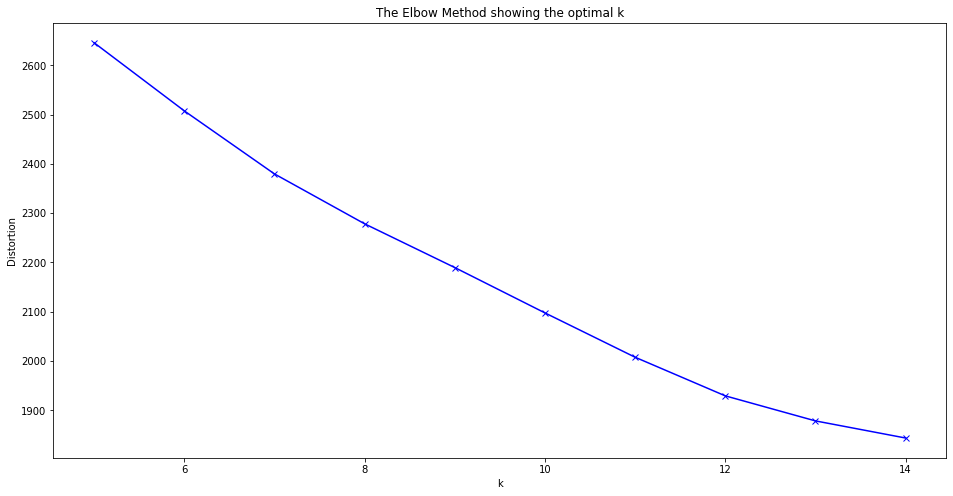

In [30]:
plt.figure(figsize=(16,8))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Analysis

We can now look at the relative size of each cluster.

In [41]:
num_clusters = 12
test_model = KMeans(n_clusters = num_clusters, random_state = 1)
test_model.fit(num_data)
df['Cluster'] = test_model.labels_
df['Cluster'].value_counts()

0     82
8     70
10    51
2     41
11    38
3     38
5     35
7     32
4     23
1     22
6      7
9      1
Name: Cluster, dtype: int64

In [42]:
df[df['Cluster'] == 9] # Gary Clark: outlier in 3/2FGA

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,O/DRTG,3/2FGA,%FTA,Cluster
76,Gary Clark,Hou,F,24.4,51,12.6,26.2,10.9,4.3,7,...,8.285714,1.142857,6.571429,1.514286,0.4,1.114286,1.018779,10.615385,0.044304,9


We can also look at the distribution by position within each cluster.

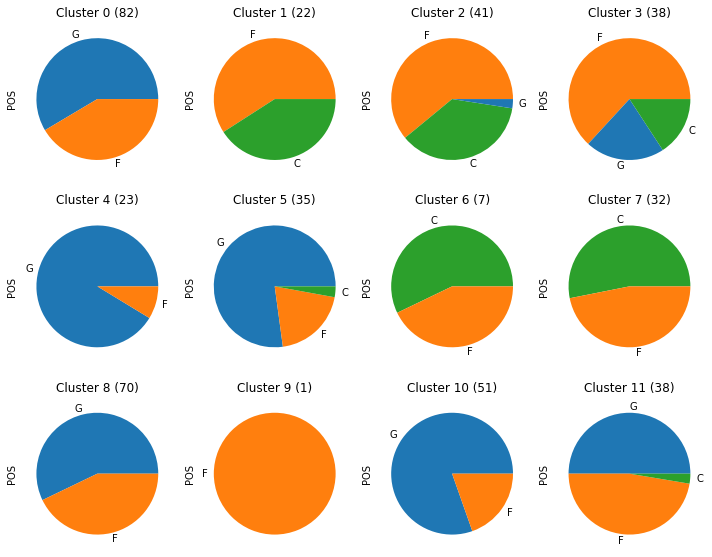

In [77]:
colours = {'G': 'C0', 'F': 'C1', 'C': 'C2'}
plt.subplots(3, 4, figsize=(10, 8))
for i in range(num_clusters):
    plt.subplot(3, 4, i+1)
    counts = df[df['Cluster'] == i]['POS'].value_counts()
    labels = list(counts.index)
    counts.plot.pie(labels=labels, colors=[colours[key] for key in labels])
    plt.title("Cluster " + str(i) + " (" + str(counts.sum()) + ")")
plt.tight_layout()
plt.show()

In [36]:
for i in range(10):
    print("Cluster "+ str(i))
    print(df[df['Cluster'] == i]['FULL NAME'].values[:])
    print()

Cluster 0
['Kadeem Allen' 'D.J. Augustin' 'Kent Bazemore' "DeAndre' Bembry"
 'Eric Bledsoe' 'Bogdan Bogdanovic' 'Alex Caruso' 'Darren Collison'
 'Jamal Crawford' 'Goran Dragic' 'Kris Dunn' 'Tyreke Evans' 'Dante Exum'
 'Markelle Fultz' 'Harry Giles III' 'Shai Gilgeous-Alexander'
 "Devonte' Graham" 'Devin Harris' 'Gordon Hayward' 'Mario Hezonja'
 'Aaron Holiday' 'Joe Ingles' 'Josh Jackson' 'James Johnson' 'Tyus Jones'
 'Walter Lemon Jr.' 'Caris LeVert' 'Kyle Lowry' 'Frank Mason'
 'Khris Middleton' 'Emmanuel Mudiay' 'Shabazz Napier' 'Raul Neto'
 'Tony Parker' 'Chandler Parsons' 'Chris Paul' 'Theo Pinson'
 'Chasson Randle' 'Ricky Rubio' 'Tomas Satoransky' 'Dennis Schroder'
 'Marcus Smart' 'Lance Stephenson' 'Jeff Teague' 'Isaiah Thomas'
 'Allonzo Trier' 'Fred VanVleet' 'Tyrone Wallace' 'Brad Wanamaker'
 'Derrick White' 'Justise Winslow' 'Jeremy Lin' 'Cameron Payne'
 'Stanley Johnson' 'Dennis Smith Jr.' 'Shelvin Mack'
 'Michael Carter-Williams' 'Jonathon Simmons']

Cluster 1
['Alex Abrines'

Finally, we can look at the distribution of specific statistics within each cluster and contrast.

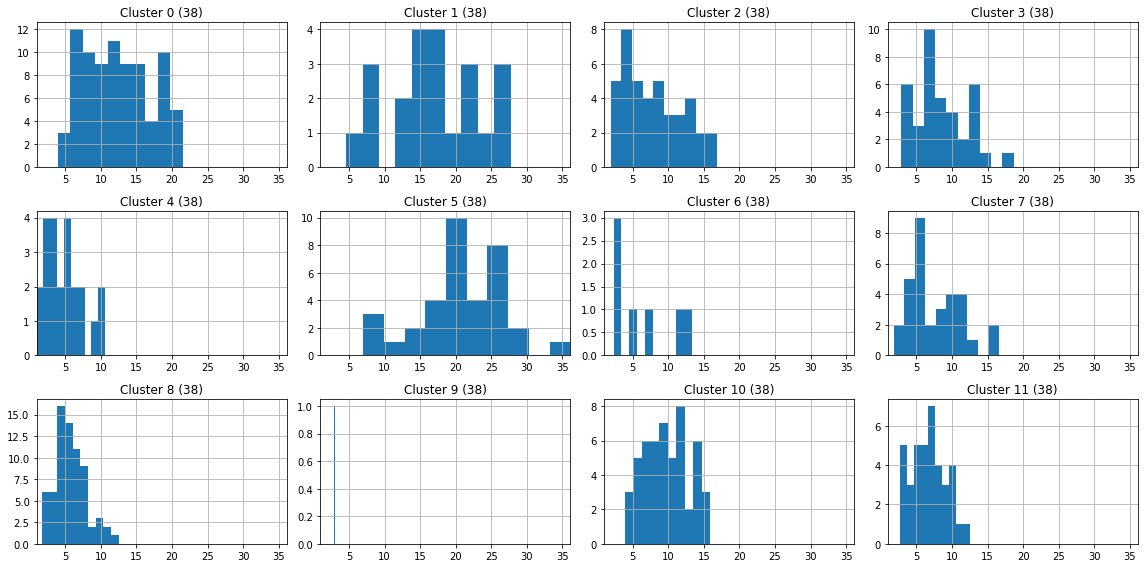

In [93]:
stat = 'PPG'
plt.subplots(3, 4, figsize=(16, 8))
for i in range(num_clusters):
    plt.subplot(3, 4, i+1)
    stats = df[df['Cluster'] == i][stat]
    stats.hist()
    plt.title("Cluster " + str(i) + " (" + str(counts.sum()) + ")")
    plt.xlim(df[stat].min(), df[stat].max())
plt.tight_layout()
plt.show()

In [90]:
df.groupby('Cluster')[['PPG', 'APG', 'RPG', 'eFG%', '3P%', '3/2FGA']].mean()

,PPG,APG,RPG,eFG%,3P%,3/2FGA
Cluster,,,,,,
0,12.298276,1.989449,3.577677,0.519472,0.366608,0.821643
1,16.793076,2.335264,9.317214,0.553823,0.286870,0.186221
2,7.948860,1.435206,4.912355,0.533896,0.247158,0.366938
3,8.377871,1.317481,4.524132,0.520877,0.309915,0.547928
4,4.797901,2.996870,2.618989,0.436593,0.287637,0.817955
5,20.937143,5.805714,5.174286,0.512114,0.324914,0.535338
6,6.528571,0.614286,4.542857,0.623857,0.113571,0.186120
7,7.644659,1.132231,5.884601,0.598948,0.146296,0.109365
8,5.758366,1.496269,2.766138,0.485737,0.315192,0.971848
